In [1]:
#https://reasonabledeviations.com/2018/04/19/classifying-timeseries/
#https://jpinjpblog.wordpress.com/2019/04/16/using-sklearns-sgdclassifier-with-partial_fit-and-generators-gridsearchcv/
#https://www.kaggle.com/nsrose7224/sgdclassifier
#https://progstat.com/Python/
import numpy as np 
import pandas as pd 
import os
import math
from scipy.stats import pearsonr
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDRegressor

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.linear_model import SGDClassifier # Stochastic Gradient Descent (SGD) for samples > 100K

sns.set(style='ticks', context='talk')
plt.style.use('dark_background')

## Fonctions utiles

In [2]:
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [45]:
def generate_modulus_dataset(X, k):
    out = np.abs(np.fft.fft(X)) # [:, :k])
    print(f"""Forme: {out.shape}; type: {type(out)}""")
    return out

def generate_complex_dataset(X, k):
    fourier = np.fft.fft(X) #[:, :k]
    out = np.column_stack((fourier.real, fourier.imag))
    print(f"""Forme: {out.shape}; type: {type(out)}""")
    #out = pd.DataFrame(out,columns = [ "Col"+str(i) for i in range(out.shape[1])]) 
    return out

# Chargement du jeu de données

In [4]:
path ='/content/drive/My Drive/TER'
path = r"""C:\Users\tpailhas\MIASHS\TER\Parkinson\ProjectCode"""
os.listdir(path)

['.ipynb_checkpoints',
 'DataWalkFromTxtToPd.ipynb',
 'plot.ipynb',
 'SGD-Tuto.ipynb',
 'tf_seg_new.ipynb',
 'UCI_HAR_Dataset',
 'WalkSessionsClassificationV1_5.ipynb',
 'X_test.csv',
 'X_train.csv',
 'Y_test.csv',
 'Y_train.csv']

In [57]:
X_train = pd.read_csv(os.path.join(path, "X_train.csv"), sep=";")
Y_train = pd.read_csv(os.path.join(path, "Y_train.csv"), sep=";")
X_test  = pd.read_csv(os.path.join(path, "X_test.csv"), sep=";")
Y_test  = pd.read_csv(os.path.join(path, "Y_test.csv"), sep=";")

print("""***** Forme des donnéees récupérées **********************""")
print(f"""{type(X_train)} {X_train.shape} """)
print(f"""{type(Y_train)} {Y_train.shape} """)
print(f"""{type(X_test)} {X_test.shape} """)
print(f"""{type(Y_test)} {Y_test.shape} """)


***** Forme des donnéees récupérées **********************
<class 'pandas.core.frame.DataFrame'> (531456, 6) 
<class 'pandas.core.frame.DataFrame'> (531456, 1) 
<class 'pandas.core.frame.DataFrame'> (59392, 6) 
<class 'pandas.core.frame.DataFrame'> (59392, 1) 


In [58]:
print(X_train.head())
print(Y_train.head())
print(X_test.head())
print(Y_test.head())

      AccX     AccY     AccZ      GyrX      GyrY      GyrZ
0  5.94531  4.35938  7.28516  0.275635  0.072632  0.369629
1  5.84766  4.39844  7.22656  0.197144  0.109314  0.319336
2  5.94531  4.45703  7.18750  0.277100  0.160034  0.284424
3  5.88672  4.43750  7.18750  0.229980  0.148560  0.281982
4  5.88672  4.39844  7.14844  0.231445  0.121582  0.246582
   Walk
0     0
1     0
2     0
3     0
4     0
      AccX      AccY     AccZ      GyrX      GyrY      GyrZ
0 -9.32813 -0.506348  1.67773 -0.037140  0.079285  0.447266
1 -9.54688 -0.564941  1.75586 -0.202271  0.016342  0.420410
2 -9.28906 -0.663086  1.67773  0.042145 -0.065369  0.273682
3 -9.37500 -0.682617  1.48144 -0.029068 -0.067993  0.062012
4 -9.23438 -0.820312  1.01074  0.086609 -0.164185 -0.326904
   Walk
0     0
1     0
2     0
3     0
4     0


In [59]:
print(X_train.info())
print(Y_train.info())
print(X_test.info())
print(Y_test.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531456 entries, 0 to 531455
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AccX    531456 non-null  float64
 1   AccY    531456 non-null  float64
 2   AccZ    531456 non-null  float64
 3   GyrX    531456 non-null  float64
 4   GyrY    531456 non-null  float64
 5   GyrZ    531456 non-null  float64
dtypes: float64(6)
memory usage: 24.3 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531456 entries, 0 to 531455
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   Walk    531456 non-null  int64
dtypes: int64(1)
memory usage: 4.1 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59392 entries, 0 to 59391
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AccX    59392 non-null  float64
 1   AccY    59392 non-null  float64
 2   AccZ    59392 non-

In [60]:
# On centre / réduit les données entre -1 and 1
scaler = StandardScaler()
#scaler.fit(X_train)  # fit only on training data
#X_train = scaler.transform(X_train)
# scaler transforme en numpy. On le convertit en Dataframe
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns = X_train.columns) 
X_test  = pd.DataFrame(scaler.fit_transform(X_test),columns = X_test.columns) 

In [61]:
X_train

,AccX,AccY,AccZ,GyrX,GyrY,GyrZ
0,1.390705,1.095715,1.362134,0.131822,0.042201,0.183640
1,1.369699,1.100541,1.348898,0.090780,0.057681,0.160623
2,1.390705,1.107780,1.340075,0.132588,0.079085,0.144646
3,1.378101,1.105367,1.340075,0.107949,0.074243,0.143529
4,1.378101,1.100541,1.331253,0.108715,0.062858,0.127328
...,...,...,...,...,...,...
531451,-0.529332,-0.646469,-0.568337,-0.057495,0.087224,-0.232220
531452,-0.523029,-0.658051,-0.571203,-0.036464,0.042201,-0.187193
531453,-0.534374,-0.668668,-0.590174,-0.053634,0.006178,-0.177472
531454,-0.527230,-0.674459,-0.595468,-0.031373,-0.007290,-0.147863


In [62]:
# Affichage des données centrées/réduites
print(X_train.head())
print(Y_train.head())
print(X_test.head())
print(Y_test.head())

       AccX      AccY      AccZ      GyrX      GyrY      GyrZ
0  1.390705  1.095715  1.362134  0.131822  0.042201  0.183640
1  1.369699  1.100541  1.348898  0.090780  0.057681  0.160623
2  1.390705  1.107780  1.340075  0.132588  0.079085  0.144646
3  1.378101  1.105367  1.340075  0.107949  0.074243  0.143529
4  1.378101  1.100541  1.331253  0.108715  0.062858  0.127328
   Walk
0     0
1     0
2     0
3     0
4     0
       AccX      AccY      AccZ      GyrX      GyrY      GyrZ
0 -1.954919  0.423887  0.132407 -0.038322  0.054214  0.209156
1 -2.004136  0.416932  0.150973 -0.121048  0.028229  0.196692
2 -1.946128  0.405281  0.132407  0.001397 -0.005505  0.128594
3 -1.965464  0.402963  0.085763 -0.034279 -0.006588  0.030355
4 -1.933826  0.386617 -0.026088  0.023672 -0.046300 -0.150146
   Walk
0     0
1     0
2     0
3     0
4     0


In [63]:
# Méthode manuelle pour centrer/réduire
#mean = X.mean(axis=0)
#std = X.std(axis=0)
#X = (X - mean) / std

In [64]:
print("""***** Forme des donnéees récupérées **********************""")
print(f"""{type(X_train)} {X_train.shape} """)
print(f"""{type(Y_train)} {Y_train.shape} """)
print(f"""{type(X_test)} {X_test.shape} """)
print(f"""{type(Y_test)} {Y_test.shape} """)

***** Forme des donnéees récupérées **********************
<class 'pandas.core.frame.DataFrame'> (531456, 6) 
<class 'pandas.core.frame.DataFrame'> (531456, 1) 
<class 'pandas.core.frame.DataFrame'> (59392, 6) 
<class 'pandas.core.frame.DataFrame'> (59392, 1) 


In [73]:
modulus_5 = generate_modulus_dataset(X_train, 5)
modulus_15 = generate_modulus_dataset(X_train, 5)
#modulus_30 = generate_modulus_dataset(X_train, 5)
#complex_5 = generate_complex_dataset(X_train, 5)
#complex_15 = generate_complex_dataset(X_train, 15)
#complex_30 = generate_complex_dataset(X_train, 30)

cv_results = []
cv_results.append(cross_val_score(RandomForestClassifier(random_state=3), X_train, y=Y_train, scoring='accuracy', cv=kfold, n_jobs=4)) 
cv_results.append(cross_val_score(RandomForestClassifier(random_state=3), modulus_5, y=Y_train, scoring='accuracy', cv=kfold, n_jobs=4)) 
#cv_results.append(cross_val_score(RandomForestClassifier(random_state=3), modulus_15, y=Y_train, scoring='accuracy', cv=kfold, n_jobs=4)) 
#cv_results.append(cross_val_score(RandomForestClassifier(random_state=3), modulus_30, y=Y_train, scoring='accuracy', cv=kfold, n_jobs=4)) 
#cv_results.append(cross_val_score(DecisionTreeClassifier(random_state=3), complex_5, y=Y_train, scoring='accuracy', cv=kfold, n_jobs=4)) 
#cv_results.append(cross_val_score(DecisionTreeClassifier(random_state=3), complex_15, y=Y_train, scoring='accuracy', cv=kfold, n_jobs=4)) 
#cv_results.append(cross_val_score(DecisionTreeClassifier(random_state=3), complex_30, y=Y_train, scoring='accuracy', cv=kfold, n_jobs=4)) 



Forme: (531456, 6); type: <class 'numpy.ndarray'>
Forme: (531456, 6); type: <class 'numpy.ndarray'>
Forme: (531456, 6); type: <class 'numpy.ndarray'>


# ML

In [55]:
# Stratification
# Dans le cas d’un problème de classification, on créée les k folds de sorte à ce qu’elles contiennent 
# à peu près les mêmes proportions d’exemples de chaque classe que le jeu de données complet. 
# On cherche à éviter qu’un jeu d’entraînement ne contienne que des exemples positifs et que le jeu de test 
# correspondant ne contienne que des exemples négatifs, ce qui va affecter négativement la performance du modèle!
# Si l’on ne répartit pas les points positifs de manière équilibrée entre les différents folds, 
# les jeux d’entraînement et de test auront des proportions différentes de positifs et négatifs, ce qui peut biaiser 
# les résultats
# La méthode model_selection.StratifiedKFold permet de créer les folds d’une validation croisée stratifiée.
# Dans le cas d’un problème de classification, on fait attention à stratifier 
# la validation croisée pour éviter d’introduire des biais.
kfold = StratifiedKFold(n_splits=5)

In [13]:
random_state=3
classifiers = []
#classifiers.append(SVC(random_state=random_state))
#classifiers.append(DecisionTreeClassifier(random_state=random_state))
#classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
#classifiers.append(ExtraTreesClassifier(random_state=random_state))
#classifiers.append(GradientBoostingClassifier(random_state=random_state))
#classifiers.append(MLPClassifier(random_state=random_state))
#classifiers.append(KNeighborsClassifier())
#classifiers.append(LogisticRegression(random_state=random_state))
#classifiers.append(LinearDiscriminantAnalysis())
#classifiers.append(SGDClassifier())

Le cassifieur 0 a pour accuracy moyenne 0.709133399155907
Le cassifieur 1 a pour accuracy moyenne 0.6771567755800258


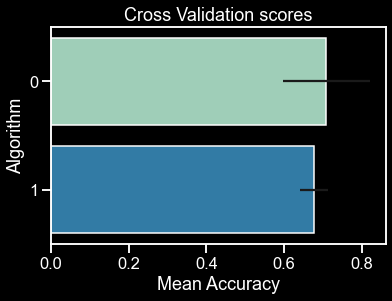

In [75]:
cv_means = []
cv_std   = []
for cv_result in cv_results:
    cv_means.append( cv_result.mean() )
    cv_std.append(   cv_result.std()  )

cv_res = pd.DataFrame({'CrossValMeans':cv_means, 'CrossValerrors':cv_std,
                       'Algorithm':[i for i in range(2)]
                      })

for row in cv_res.itertuples(index=True, name='Pandas'):
    print("Le cassifieur {0} a pour accuracy moyenne {1}".format(getattr(row, "Algorithm"),getattr(row, "CrossValMeans")))
    
g = sns.barplot('CrossValMeans','Algorithm', data=cv_res, palette='YlGnBu', orient='h', **{'xerr':cv_std})
g = g.set(title='Cross Validation scores',xlabel='Mean Accuracy')


# Boosting
### Principe: évaluer une séquence de classifieurs faibles (weak learners) sur plusieurs versions légèrement modifiées des données d’apprentissage. Les décisions obtenues sont alors combinées par une somme ponderée pour obtenir le modèle final.
### Avec scikit-learn, c’est la classe AdaBoostClassifier qui implémente cet algorithme. Les paramètres les plus importants sont :
###         n_estimators : integer, optional (default=10). Le nombre de classifieurs faibles.
###         learning_rate : contrôle la vitesse de changement des poids par itération.
###         base_estimator : (default=DecisionTreeClassifier) le classifieur faible utilisé.

In [24]:
dataset

,Col0,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11
0,4.206217,1.196393,0.180681,1.383863,0.180681,1.196393,0.0,-1.932976,0.353215,1.110223e-16,-0.353215,1.932976
1,4.128222,1.206212,0.126607,1.424334,0.126607,1.206212,0.0,-1.932219,0.304234,1.110223e-16,-0.304234,1.932219
2,4.194878,1.174749,0.187499,1.424851,0.187499,1.174749,0.0,-1.926148,0.257952,2.220446e-16,-0.257952,1.926148
3,4.149264,1.187440,0.154444,1.435575,0.154444,1.187440,0.0,-1.929219,0.263267,1.110223e-16,-0.263267,1.929219
4,4.108797,1.186265,0.175827,1.435628,0.175827,1.186265,0.0,-1.941290,0.255635,1.110223e-16,-0.255635,1.941290
...,...,...,...,...,...,...,...,...,...,...,...,...
531451,-1.946629,-0.670624,0.093073,-0.074262,0.093073,-0.670624,0.0,0.926483,-0.208983,-1.110223e-16,0.208983,-0.926483
531452,-1.933739,-0.644686,0.127630,-0.170324,0.127630,-0.644686,0.0,0.938999,-0.123449,-5.551115e-17,0.123449,-0.938999
531453,-2.018145,-0.611812,0.127061,-0.218596,0.127061,-0.611812,0.0,0.941844,-0.091067,-5.551115e-17,0.091067,-0.941844
531454,-1.983685,-0.605639,0.153937,-0.276293,0.153937,-0.605639,0.0,0.965422,-0.053332,0.000000e+00,0.053332,-0.965422


In [ ]:
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {'base_estimator__criterion':['gini', 'entropy'],
                  'base_estimator__splitter' :['best', 'random'],
                  'algorithm'                :['SAMME', 'SAMME.R'],
                  'n_estimators'             :[1,2],
                  'learning_rate'            :[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]}

gsadaDTC = GridSearchCV( adaDTC, param_grid=ada_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1 )
gsadaDTC.fit(X_train,Y_train)
ada_best = gsadaDTC.best_estimator_
print(gsadaDTC.best_params_)
print(gsadaDTC.best_score_)

In [ ]:
#print(ada_best)
print("***BEST PARAMS********")
print(gsadaDTC.best_params_)
print("***BEST SCORE********")
print(gsadaDTC.best_score_)

## Evaluation du modèle
### •Utiliser différente métriques de sklearn.metrics pour évaluer les performances du modèle
### •Afficher la matrice de confusion grace à la fonction plot_confusion_matrix


In [ ]:
#Y_pred_test = gsadaDTC.predict(X_test)
Y_pred_train = gsadaDTC.predict(X_train)

In [ ]:
# evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

cm = confusion_matrix(Y_train, Y_pred_train)
#print(cm)
plot_confusion_matrix(cm, ["Echec", "Succès"])
print("Accuracy train {}".format(accuracy_score(Y_train, Y_pred_train)))
print("Precision train {}".format(precision_score(Y_train, Y_pred_train)))
print("Recall train {}".format(recall_score(Y_train, Y_pred_train)))
#print("Accuracy test {}".format(accuracy_score(Y_test, Y_pred_test)))
#print("Precision test {}".format(precision_score(Y_test, Y_pred_test)))
#print("Recall test {}".format(recall_score(Y_test, Y_pred_test)))


In [ ]:
from sklearn import metrics
print(metrics.classification_report(Y_train, Y_pred_train))

# ROC curve

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from scipy import interp

# Classification and ROC analysis
random_state = 42
# Run classifier with cross-validation and plot ROC curves
#cv = StratifiedKFold(n_splits=3)
#classifier = SVC(kernel='linear', probability=True,
#                     random_state=random_state)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))
i = 0
for train, test in kfold.split(X, y):
    #clf = classifier.fit(X.loc[train], Y.loc[train])
    clf = gsadaDTC.fit(X.loc[train], y.loc[train])
    
    probas_ =  clf.predict_proba(X.loc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y.loc[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# define the parameter values that should be searched
# for python 2, k_range = range(1, 31)
knn = KNeighborsClassifier()
k_range = list(range(1, 31))
ex_param_grid = dict(n_neighbors=k_range)
gsKnn = GridSearchCV(knn, param_grid=ex_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsKnn.fit(X_train, Y_train)

knn_best = gsKnn.best_estimator_
print(knn_best)
print(gsKnn.best_score_)

In [ ]:
# create a list of the mean scores only
# list comprehension to loop through grid.grid_scores
grid_mean_scores = [result.mean_validation_score for result in gsKnn.grid_scores_]
print(grid_mean_scores)

In [ ]:
ExtC = ExtraTreesClassifier()

ex_param_grid = {'max_depth'        :[None],
                 'max_features'     :[1, 1, 1],
                 'min_samples_split':[2, 3, 7],
                 'min_samples_leaf' :[1, 3, 7],
                 'bootstrap'        :[False],
                 'n_estimators'     :[100, 300],
                 'criterion'        :['gini']}

gsExtC = GridSearchCV(ExtC, param_grid=ex_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsExtC.fit(X_train, Y_train)

ExtC_best = gsExtC.best_estimator_

gsExtC.best_score_

In [ ]:
RFC = RandomForestClassifier()

rf_param_grid = {'max_depth'        :[None],
                 'max_features'     :[1, 4, 1],
                 'min_samples_split':[2, 3, 7],
                 'bootstrap'        :[False],
                 'n_estimators'     :[100, 300],
                 'criterion'        :['gini']}

gsRFC = GridSearchCV(RFC, param_grid=rf_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsRFC.fit(X_train, Y_train)
RFC_best = gsRFC.best_estimator_

gsRFC.best_score_

In [ ]:
GBC = GradientBoostingClassifier()

gb_param_grid = {'loss'            :['deviance'],
                 'n_estimators'    :[100, 200, 300],
                 'learning_rate'   :[0.001, 0.01, 0.1, 1, 10, 100],
                 'max_depth'       :[4, 8],
                 'min_samples_leaf':[100, 150],
                 'max_features'    :[0.3, 0.1]
                }

gsGBC = GridSearchCV( GBC, param_grid=gb_param_grid, cv=kfold, scoring='accuracy',n_jobs=4, verbose=1 )

gsGBC.fit(X_train, Y_train)
GBC_best = gsGBC.best_estimator_

gsGBC.best_score_

In [ ]:
SVMC = SVC(probability=True)
svc_param_grid = {'kernel':['rbf'],
                  'gamma' :[0.001, 0.01, 0.1, 1, 10, 100],
                  'C'     :[1, 10,  100, 400,  800, 1000]}

gsSVMC = GridSearchCV(SVMC, param_grid=svc_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

gsSVMC.fit(X_train, Y_train)
SVMC_best = gsSVMC.best_estimator_

gsSVMC.best_score_

In [ ]:
parameters = {'solver':['adam'], 'max_iter':[800], 'alpha':10.0**-np.arange(1,10), 'hidden_layer_sizes':[40,20,10], 'random_state':[0,1] }
gsMLPC=GridSearchCV(MLPClassifier(), parameters, n_jobs=-1)

gsMLPC.fit(X_train, Y_train)
MLPC_best = gsMLPC.best_estimator_

gsMLPC.best_score_

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean( train_scores, axis=1 )
    train_scores_std  = np.std(  train_scores, axis=1 )
    test_scores_mean  = np.mean( test_scores, axis=1  )
    test_scores_std   = np.std(  test_scores, axis=1  )
    
    plt.fill_between( train_sizes, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std, alpha=0.1, color='r' )
    plt.fill_between( train_sizes, test_scores_mean-train_scores_std,  test_scores_mean+train_scores_std,  alpha=0.1, color='g' )
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean,  'o-', color='g', label='Cross-validation score')
    plt.legend(loc='best')
    return plt

In [ ]:
g1 = plot_learning_curve( gsGBC.best_estimator_,    'Gradient Boosting Learning Curve', X_train, Y_train, cv=kfold )
g2 = plot_learning_curve( gsExtC.best_estimator_,   'ExtraTrees learning curves',       X_train, Y_train, cv=kfold )
g3 = plot_learning_curve( gsSVMC.best_estimator_,   'SVC learning curves',              X_train, Y_train, cv=kfold )
g4 = plot_learning_curve( gsadaDTC.best_estimator_, 'AdaBoost learning curves',         X_train, Y_train, cv=kfold )
g5 = plot_learning_curve( gsRFC.best_estimator_,    'RF meaning curves',                X_train, Y_train, cv=kfold )
g6 = plot_learning_curve( gsMLPC.best_estimator_,   'MLP meaning curves',               X_train, Y_train, cv=kfold )

In [ ]:
nrows = 2
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex='all', figsize=(15,15))

names_classifiers = [('AdaBoosting', ada_best),('ExtraTrees',ExtC_best),('RandomForest',RFC_best),('GradientBoosting',GBC_best),("MLP",MLPC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x=classifier.feature_importances_[indices][:40], orient='h', ax=axes[row][col])
        g.set_xlabel('Relative importance', fontsize=12)
        g.set_ylabel('Features', fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name+' feature importance')
        nclassifier +=1

In [ ]:
test_Survived_RFC  = pd.Series(RFC_best.predict(test),  name='RFC' )
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name='ExtC')
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name='SVC' )
test_Survived_AdaC = pd.Series(ada_best.predict(test),  name='Ada' )
test_Survived_GBC  = pd.Series(GBC_best.predict(test),  name='GBC' )
test_Survived_MLP  = pd.Series(MLPC_best.predict(test), name='MLP' )

ensemble_results = pd.concat( [test_Survived_RFC, test_Survived_ExtC, test_Survived_SVMC, test_Survived_AdaC, test_Survived_GBC, test_Survived_MLP], axis=1 )
g = sns.heatmap(ensemble_results.corr(), annot=True, annot_kws={'size':12})

In [ ]:
votingC = VotingClassifier(estimators = [('rfc',RFC_best),('extc',ExtC_best),('svc',SVMC_best),('adac',ada_best),('gbc',GBC_best),('mlp',MLPC_best)],voting='soft',n_jobs=4)
votingC = votingC.fit(X_train, Y_train)

In [ ]:
test_Survived = pd.Series(votingC.predict(test), name='Survived')

results = pd.concat([IDtest, test_Survived],axis=1)

results.to_csv('32_submission.csv', index=False)

In [ ]:
# test_Survived = gsGBC.predict(test)

# submission = pd.DataFrame({
#     'PassengerId' : IDtest,
#     'Survived' : test_Survived
# })

# submission.to_csv('my_first_submission.csv', index=False)

In [ ]:
# test_Survived = gsSVMC.predict(test)

# submission = pd.DataFrame({
#     'PassengerId' : IDtest,
#     'Survived' : test_Survived
# })

# submission.to_csv('submission_31th.csv', index=False)

In [ ]:
# test_Survived = mlp.predict(test)

# submission = pd.DataFrame({
#     'PassengerId' : IDtest,
#     'Survived' : test_Survived
# })

# submission.to_csv('my_NN_submission.csv', index=False)

# SGD Classifier

In [ ]:
# Implementing Linear_SGD classifier
from sklearn.linear_model import SGDClassifier
sgd_param_grid = {'loss'            :["hinge", "log", "perceptron", "squared_hinge", "modified_huber"],
                 'penalty'         :['l2', 'l1', 'elasticnet', 'none'],
                 'max_iter'        : [5, 10, 20, 50, 100, 1000, 10000, 20000],
                 'alpha'           : [10 ** x for x in range(-6, 3)]} # ** = puissance()
                  # [0.0001, 0.001, 0.01, 0.1, 1, 2, 10, 20, 50]}

SGD = SGDClassifier() # ex clf
GS_SGD = GridSearchCV(estimator=SGD, param_grid=sgd_param_grid, cv=5, scoring='accuracy',n_jobs=4, verbose=1 )
GS_SGD.fit(X_train, Y_train)

In [ ]:
# https://www.kaggle.com/nsrose7224/sgdclassifier
# GridSearchCV will run all the combinations of all those parameters to find out which provides 
# the best accuracy. 
# best_estimator_ will print the parameters used to achieve the best_score_.
# print(GS_SGD.best_estimator_) la memê chose que best_params_ en moins complet
print(GS_SGD.best_params_)
print(GS_SGD.best_score_)
# GridSearchCV object has no attribute 'coef_  'intercept_'




In [ ]:
y_train_pred = GS_SGD.predict(X_train)

In [ ]:
y_train_pred

In [ ]:
# evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

cm = confusion_matrix(Y_train, y_train_pred)
#print(cm)
plot_confusion_matrix(cm, ["0", "1"])
print("Accuracy train {}".format(accuracy_score(Y_train, y_train_pred)))
print("Precision train {}".format(precision_score(Y_train, y_train_pred)))
print("Recall train {}".format(recall_score(Y_train, y_train_pred)))